# NoisePy tutorial: Monitoring 

This tutorial will demonstrate how to use NoisePy's output to perform monitoring on correlations: measuring of changes in seismic velocities and intrinsic atteunation parameters (for single-station measurement).
- Step 0. Import used modules and setup the config parameters of the noisepy output
- Step 1. Cross correlate
- Step 2. Read data from the NoisePy CCstore 
- Step 3. Look at invidual traces and make dv/v measurements
- Step 4. Measure dv/v on all cross-components
- Step 5. Measure attenuation parameter: intrinsic absorption parameter b
- Step 6. Output results as a csv file

<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vRE3QlQApkEfZ_zmLSbLS37wNwYt0EcD-Cw80nez-FB8okrMXERnwPLrQVz8yE31gd-dUJqvFcSliV9/embed?start=false&loop=false&delayms=3000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>

### Step 0 - Import modules and setup config parameters

In [1]:

import os, logging
import numpy as np
import matplotlib.pyplot as plt

from obspy.signal.filter import bandpass
from datetime import datetime, timezone
from datetimerange import DateTimeRange

from noisepy.seis import noise_module, cross_correlate
from noisepy.seis.io.asdfstore import ASDFCCStore
from noisepy.seis.io.datatypes import ConfigParameters, StackMethod, CCMethod, FreqNorm, RmResp, TimeNorm 
from noisepy.seis.io.channel_filter_store import channel_filter
from noisepy.seis.io.channelcatalog import XMLStationChannelCatalog        # Required stationXML handling object
from noisepy.seis.io.s3store import SCEDCS3DataStore    # Object to query SCEDC data from on S3
from noisepy.seis.io.plotting_modules import plot_substack_cc

from noisepy.monitoring.monitoring_utils import *     # modules for monitoring utils
from noisepy.monitoring.monitoring_methods import stretching
from noisepy.monitoring.attenuation_utils import *    # modules for attenuation monitoring


/home/niyiyu/Research/noisepy/src/noisepy/seis/io/utils.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
logger = logging.getLogger(__name__)
path = os.path.expanduser("./") # for local runs

MAX_MEM = 4

os.makedirs(path,exist_ok=True)

In [3]:
start_date = datetime(2019, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2019, 1, 31, tzinfo=timezone.utc)
print(start_date, end_date)

2019-01-01 00:00:00+00:00 2019-01-31 00:00:00+00:00


The config parameters of ccstore data

In [4]:
config = ConfigParameters() # default config parameters which can be customized

config.start_date = start_date
config.end_date = end_date

config.samp_freq= 20    # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 600      # (int) basic unit of data length for fft (sec)
    # criteria for data selection
config.ncomp = 3        # 1 or 3 component data (needed to decide whether do rotation)


config.acorr_only = True   # only perform auto-correlation or not
config.xcorr_only = False  # only perform cross-correlation or not


config.lamin = 31       # min latitude
config.lamax = 42       # max latitude
config.lomin = -124     # min longitude
config.lomax = -115     # max longitude
config.net_list = ["CI"] # network codes
config.stations = ["LJR"] # station names, e.g. ["LJR","DLA","LAF"]

 # pre-processing parameters
config.step= 600  # (int) overlapping between each cc_len (sec)
config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
config.rm_resp= RmResp.INV  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',
config.freqmin = 0.05
config.freqmax = 8.0
config.max_over_std  = 10  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# TEMPORAL and SPECTRAL NORMALISATION
config.freq_norm= FreqNorm.RMA  # choose between "rma" for a soft whitenning or "no" for no whitening. Pure whitening is not implemented correctly at this point.
config.smoothspect_N = 10  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)

config.time_norm = TimeNorm.ONE_BIT  # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
    # TODO: change time_norm option from "no" to "None"
config.smooth_N= 10  # moving window length for time domain normalization if selected (points)

config.cc_method= CCMethod.XCORR  # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
config.stack_method=StackMethod.ALL
# OUTPUTS:
num_stack=24
config.substack = True  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_len = num_stack * config.cc_len  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
    # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
    # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations

config.maxlag= 60  # lags of cross-correlation to save (sec)

### Step 1. Cross correlate.

This step will read data from S3, cross correlate, store the xcorrs on a local CCStore.

In [5]:
# S3 paths for raw data and stationXML
S3_STORAGE_OPTIONS = {"s3": {"anon": True}} # S3 storage options
S3_DATA = "s3://scedc-pds/continuous_waveforms/" # Continuous waveform data
S3_STATION_XML = "s3://scedc-pds/FDSNstationXML/CI/"    # StationXML files for CI network

In [6]:
# S3 data store
timerange=DateTimeRange(config.start_date, config.end_date)
catalog = XMLStationChannelCatalog(S3_STATION_XML, storage_options=S3_STORAGE_OPTIONS) # Station catalog
raw_store = SCEDCS3DataStore(S3_DATA, catalog, channel_filter(config.net_list, config.stations, ["BHE", "BHN", "BHZ", "HHE", "HHN", "HHZ"]), \
                             timerange, storage_options=S3_STORAGE_OPTIONS) # Store for reading raw data from S3 bucket

In [7]:
# CC store 
cc_data_path = os.path.join(path, "CCF_ASDF")
cc_store=ASDFCCStore(cc_data_path)

# For this tutorial make sure the previous run is empty
os.system(f"rm -rf {cc_data_path}")
# Cross-correlation
cross_correlate(raw_store, config, cc_store)

# Save config parameters
xcorr_config_fn='xcorr_config.yml'
config.save_yaml(xcorr_config_fn)

### Step 2: Read data from the NoisePy CCstore 

In [8]:
# This step will read correlations from the NoisePy output ASDF files (ASDFCCStore).
# --- local paths for CCs if CCs had been calculated ---
# cc_data_path = os.path.join(path, "CCF_ASDF")
# cc_store = ASDFCCStore(cc_data_path) # Store for writing CC data

List out available station pairs. Plot a single set of the correlation

pairs:  [(CI.LJR, CI.LJR)]
stations:  {CI.LJR}
[2019-01-01T00:00:00+0000 - 2019-01-02T00:00:00+0000, 2019-01-02T00:00:00+0000 - 2019-01-03T00:00:00+0000, 2019-01-03T00:00:00+0000 - 2019-01-04T00:00:00+0000, 2019-01-04T00:00:00+0000 - 2019-01-05T00:00:00+0000, 2019-01-05T00:00:00+0000 - 2019-01-06T00:00:00+0000, 2019-01-06T00:00:00+0000 - 2019-01-07T00:00:00+0000, 2019-01-07T00:00:00+0000 - 2019-01-08T00:00:00+0000, 2019-01-08T00:00:00+0000 - 2019-01-09T00:00:00+0000, 2019-01-09T00:00:00+0000 - 2019-01-10T00:00:00+0000, 2019-01-10T00:00:00+0000 - 2019-01-11T00:00:00+0000, 2019-01-11T00:00:00+0000 - 2019-01-12T00:00:00+0000, 2019-01-12T00:00:00+0000 - 2019-01-13T00:00:00+0000, 2019-01-13T00:00:00+0000 - 2019-01-14T00:00:00+0000, 2019-01-14T00:00:00+0000 - 2019-01-15T00:00:00+0000, 2019-01-15T00:00:00+0000 - 2019-01-16T00:00:00+0000, 2019-01-16T00:00:00+0000 - 2019-01-17T00:00:00+0000, 2019-01-17T00:00:00+0000 - 2019-01-18T00:00:00+0000, 2019-01-18T00:00:00+0000 - 2019-01-19T00:00:00+0000

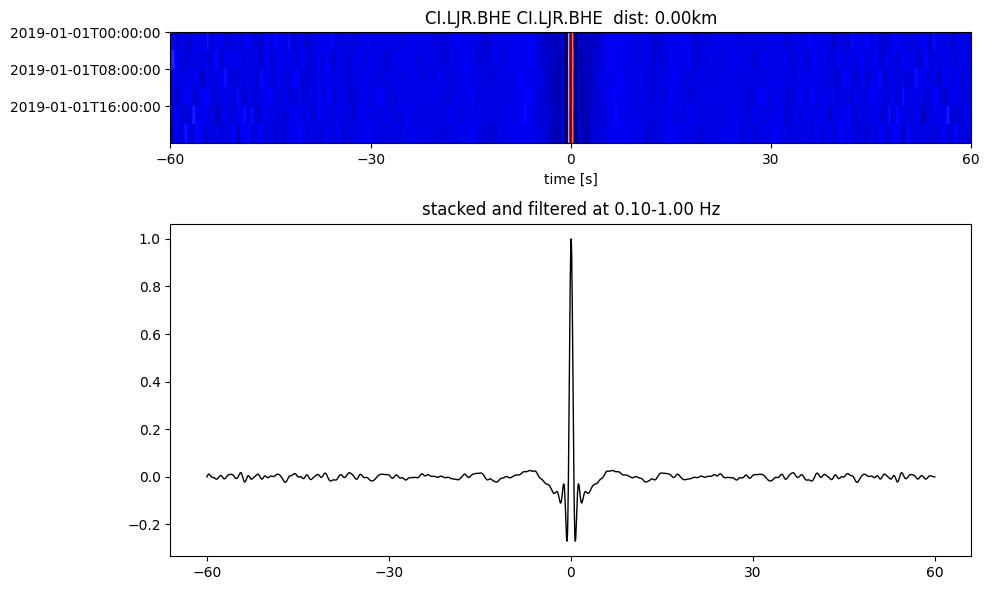

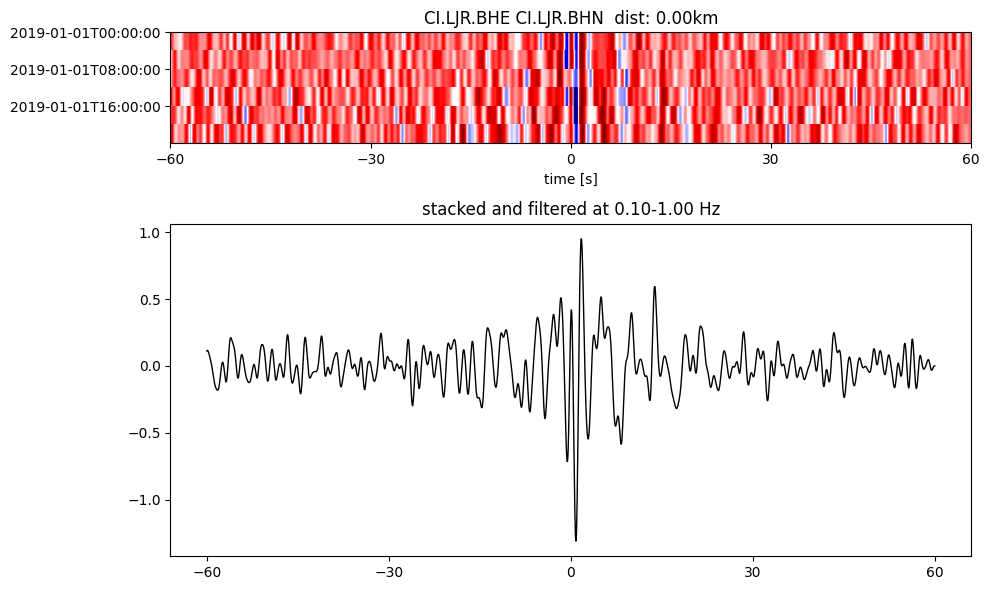

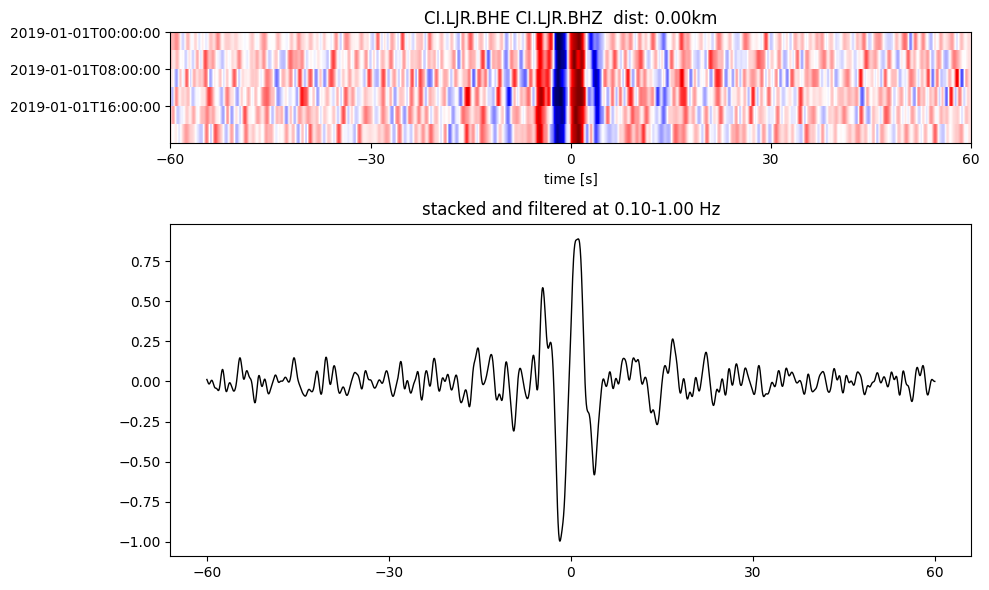

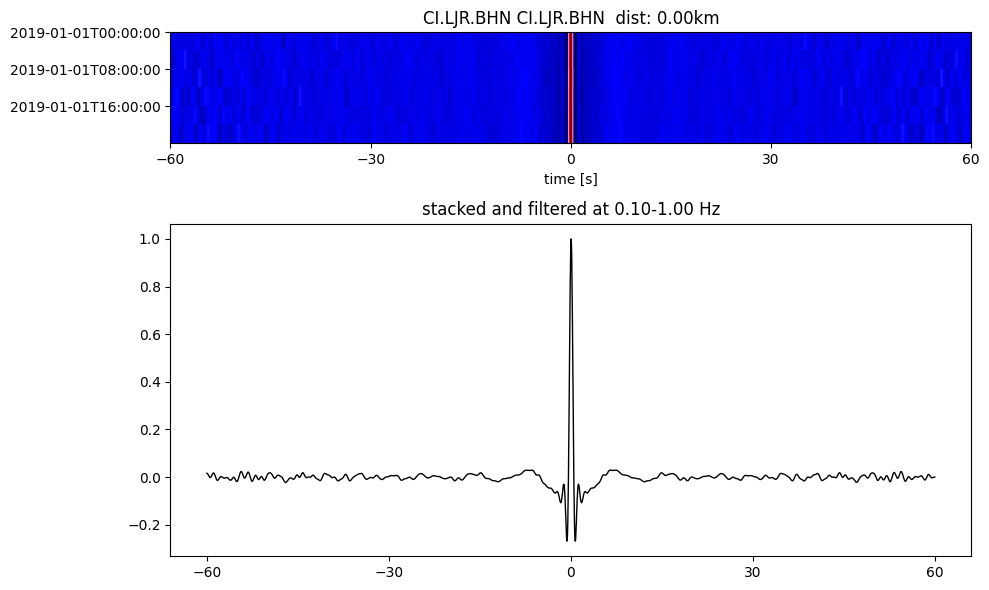

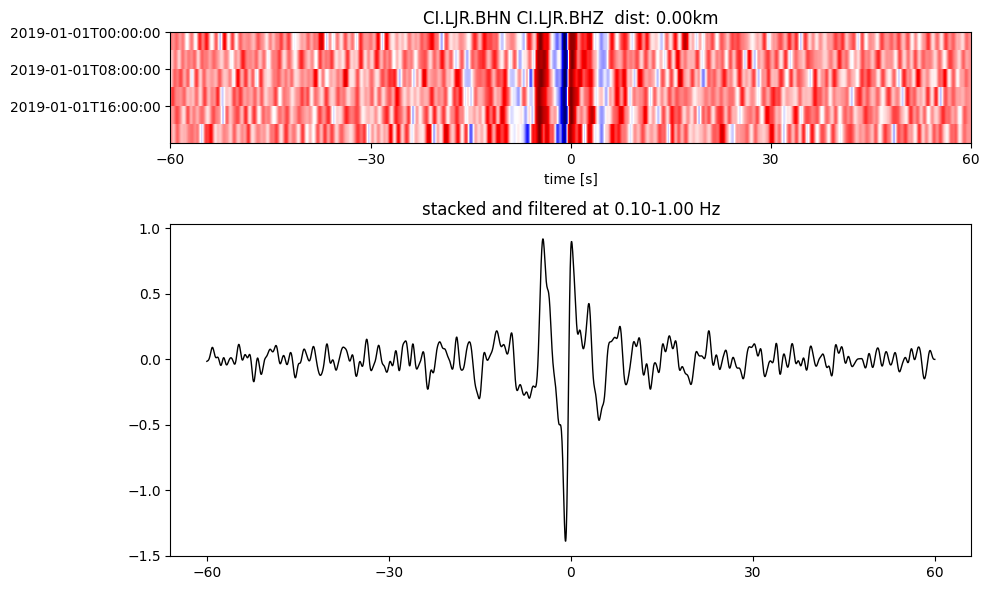

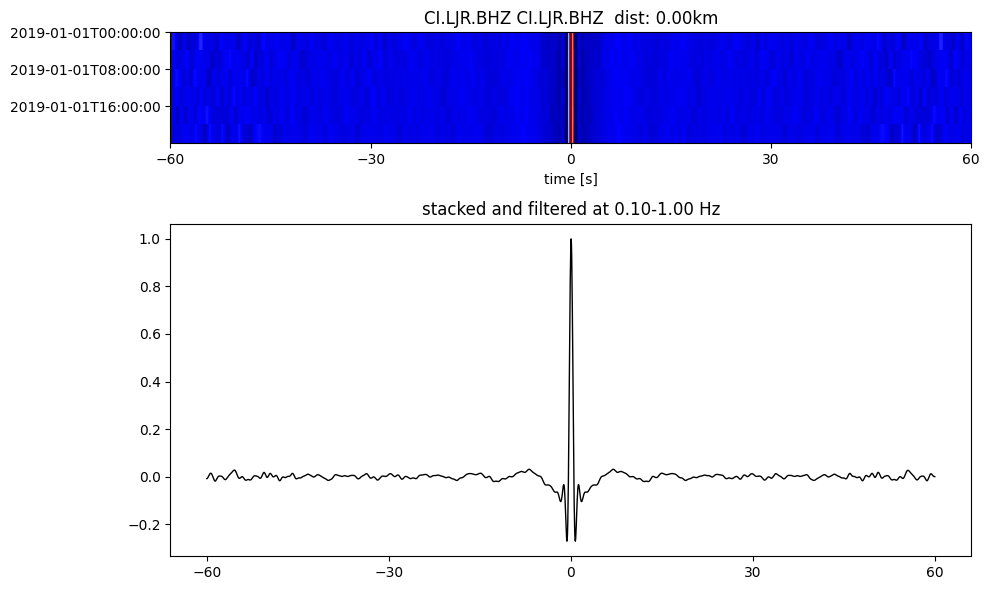

In [9]:
pairs_all = cc_store.get_station_pairs()
stations = set(pair[0] for pair in pairs_all)
print('pairs: ',pairs_all)
print('stations: ', stations)

src="CI.LJR"
rec="CI.LJR"
timespans = cc_store.get_timespans(src,rec)
print(timespans)
plot_substack_cc(cc_store, timespans[0], 0.1, 1, config.maxlag, False)

### Step 3: Look at invidual traces and make dv/v measurements

The config parameters for time-lapse seismic velocity measurement.

In [10]:
config_monito = ConfigParameters_monitoring() # default config parameters which can be customized

# --- parameters for measuring velocity changes ---
# pre-defined group velocity to window direct and code waves
config_monito.vmin = 2.0  # minimum velocity of the direct waves -> start of the coda window
config_monito.lwin = 20.0  # window length in sec for the coda waves

# basic parameters
config_monito.freq = [0.25, 0.5, 1.0]  # targeted frequency band for waveform monitoring
nfreq = len(config_monito.freq) - 1
config_monito.onelag = False  # make measurement one one lag or two
config_monito.norm_flag = True  # whether to normalize the cross-correlation waveforms
config_monito.do_stretch = True  # use strecthing method or not

# parameters for stretching method
config_monito.epsilon = 0.02  # limit for dv/v (in decimal)
config_monito.nbtrial = 50  # number of increment of dt [-epsilon,epsilon] for the streching

# coda window 
config_monito.coda_tbeg = 2.0  # begin time (sec) of the coda window in lag time
config_monito.coda_tend = 8.0  # end time (sec) of the coda window in lag time

# --- parameters for measuring attenuation ---
config_monito.smooth_winlen = 10.0  # smoothing window length
config_monito.cvel = 2.6  # Rayleigh wave velocities over the freqency bands
config_monito.atten_tbeg = 2.0
config_monito.atten_tend = 10.0
config_monito.intb_interval_base=0.01 # interval base of intrinsic absorption parameter for a grid-searching process


Choose a station pair for further measurement

In [11]:
sta_pair = pairs_all[0]
src_sta = src 
rec_sta = rec 
timespans = cc_store.get_timespans(src,rec)
print(src_sta,rec_sta)
print(timespans)

CI.LJR CI.LJR
[2019-01-01T00:00:00+0000 - 2019-01-02T00:00:00+0000, 2019-01-02T00:00:00+0000 - 2019-01-03T00:00:00+0000, 2019-01-03T00:00:00+0000 - 2019-01-04T00:00:00+0000, 2019-01-04T00:00:00+0000 - 2019-01-05T00:00:00+0000, 2019-01-05T00:00:00+0000 - 2019-01-06T00:00:00+0000, 2019-01-06T00:00:00+0000 - 2019-01-07T00:00:00+0000, 2019-01-07T00:00:00+0000 - 2019-01-08T00:00:00+0000, 2019-01-08T00:00:00+0000 - 2019-01-09T00:00:00+0000, 2019-01-09T00:00:00+0000 - 2019-01-10T00:00:00+0000, 2019-01-10T00:00:00+0000 - 2019-01-11T00:00:00+0000, 2019-01-11T00:00:00+0000 - 2019-01-12T00:00:00+0000, 2019-01-12T00:00:00+0000 - 2019-01-13T00:00:00+0000, 2019-01-13T00:00:00+0000 - 2019-01-14T00:00:00+0000, 2019-01-14T00:00:00+0000 - 2019-01-15T00:00:00+0000, 2019-01-15T00:00:00+0000 - 2019-01-16T00:00:00+0000, 2019-01-16T00:00:00+0000 - 2019-01-17T00:00:00+0000, 2019-01-17T00:00:00+0000 - 2019-01-18T00:00:00+0000, 2019-01-18T00:00:00+0000 - 2019-01-19T00:00:00+0000, 2019-01-19T00:00:00+0000 - 2019

Calculate and define the size of the data array : number of windows vs number of points.

In [12]:
# calculate the number of segments
num_chunk = len(timespans)
#num_segmts, npts_segmt = calc_segments(config, len(timespans)*config.ncomp**2, MAX_MEM)
num_segmts, npts_one_segmt = calc_segments(config, len(timespans), MAX_MEM)
print(f"there are ",num_segmts," segments/windows and ",npts_one_segmt," points in each segments and overall",num_chunk," number of time chunks")

there are  6  segments/windows and  2401  points in each segments and overall 30  number of time chunks


Declare arrays for reading in correlation data.

In [13]:
nccomp=config.ncomp**2
cc_array = np.zeros((nccomp*num_chunk * num_segmts, npts_one_segmt), dtype=np.float32)
cc_time  = np.zeros( nccomp*num_chunk * num_segmts, dtype=np.float32)
cc_ngood = np.zeros( nccomp*num_chunk * num_segmts, dtype=np.int16)
cc_comp  = np.chararray(nccomp*num_chunk * num_segmts, itemsize=2, unicode=True)
print(cc_array.shape)

(1620, 2401)


Read in data from ASDFCCStore.

In [14]:
iseg = 0
print("timespans: ",timespans)
print("station pair: ",sta_pair)
for ts in timespans:
    # read data and parameter matrix
    src_chan, rec_chan = sta_pair
    # load the n-component data, which is in order in the ASDFCCStore
    ch_pairs = cc_store.read(ts, src_sta, rec_sta)
    #print(ch_pairs)
    for ch_pair in ch_pairs:
        src_cha, rec_cha, params, all_data = ch_pair.src, ch_pair.rec, ch_pair.parameters, ch_pair.data
        try:
             
            dist, tgood, ttime = (params[p] for p in ["dist", "ngood", "time"])
            comp, dt, maxlag = (params[p] for p in [ "comp","dt", "maxlag"])
            tcmp1=str(comp)[0]
            tcmp2=str(comp)[1]
            
        except Exception as e:
            logger.warning(f"continue! something wrong with {src_sta}_{rec_sta}/{src_cha}_{rec_cha}: {e}")
            continue
        
        if config.substack:
            for ii in range(all_data.shape[0]):
                cc_array[iseg] = all_data[ii]
                cc_time[iseg] = ttime[ii]
                cc_ngood[iseg] = tgood[ii]
                cc_comp[iseg] = tcmp1 + tcmp2
                iseg += 1
        else:
            cc_array[iseg] = all_data
            cc_time[iseg] = ttime
            cc_ngood[iseg] = tgood
            cc_comp[iseg] = tcmp1 + tcmp2
            iseg += 1
            
print(len(timespans),iseg)

timespans:  [2019-01-01T00:00:00+0000 - 2019-01-02T00:00:00+0000, 2019-01-02T00:00:00+0000 - 2019-01-03T00:00:00+0000, 2019-01-03T00:00:00+0000 - 2019-01-04T00:00:00+0000, 2019-01-04T00:00:00+0000 - 2019-01-05T00:00:00+0000, 2019-01-05T00:00:00+0000 - 2019-01-06T00:00:00+0000, 2019-01-06T00:00:00+0000 - 2019-01-07T00:00:00+0000, 2019-01-07T00:00:00+0000 - 2019-01-08T00:00:00+0000, 2019-01-08T00:00:00+0000 - 2019-01-09T00:00:00+0000, 2019-01-09T00:00:00+0000 - 2019-01-10T00:00:00+0000, 2019-01-10T00:00:00+0000 - 2019-01-11T00:00:00+0000, 2019-01-11T00:00:00+0000 - 2019-01-12T00:00:00+0000, 2019-01-12T00:00:00+0000 - 2019-01-13T00:00:00+0000, 2019-01-13T00:00:00+0000 - 2019-01-14T00:00:00+0000, 2019-01-14T00:00:00+0000 - 2019-01-15T00:00:00+0000, 2019-01-15T00:00:00+0000 - 2019-01-16T00:00:00+0000, 2019-01-16T00:00:00+0000 - 2019-01-17T00:00:00+0000, 2019-01-17T00:00:00+0000 - 2019-01-18T00:00:00+0000, 2019-01-18T00:00:00+0000 - 2019-01-19T00:00:00+0000, 2019-01-19T00:00:00+0000 - 2019-0

Once the data is stored in memory, we follow these steps:
* bandpass the data in a given frequency band,
* stack to get a reference,
* measure dv/v, save it into a pandas dataframe

There are 43 window in total for stacking  (good signal windows)


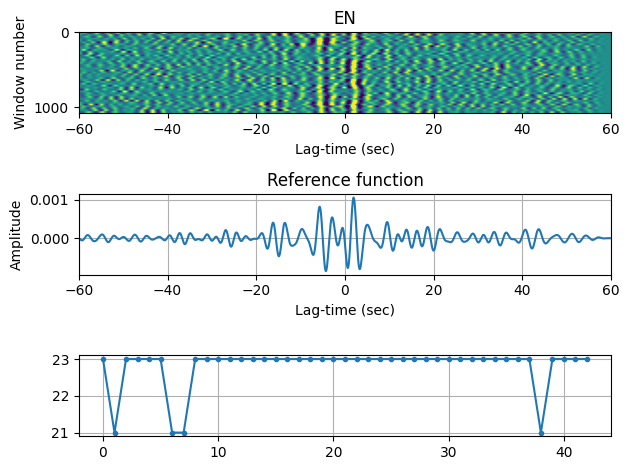

In [15]:
# in single-station cross-component case : enz_system = [ "EN", "EZ", "NZ"]
freq1=config_monito.freq[0]
freq2=config_monito.freq[1]
dt=1/config.samp_freq

## Choose a targeted component
comp = "EN"

# -- select only the data from the same cross-component cross correlations
# -- and that have sufficiently good windows
indx = np.where( (cc_comp.lower() == comp.lower()) & cc_ngood==1 )[0]
nwin = len(indx)  # number of windows to stack.
print("There are %d window in total for stacking"%nwin," (good signal windows)")

# bandpass filter the data.
tcur = np.zeros(shape=(len(indx),npts_one_segmt))
for i in range(len(indx)):
  tcur[i,:]=bandpass(cc_array[indx[i]], freq1, freq2, int(1 / dt), corners=4, zerophase=True)

# output stacked data
(
    cc_final,
    ngood_final,
    stamps_final,
    tref,
    allstacks2,
    allstacks3,
    nstacks,
) = noise_module.stacking(tcur, cc_time[indx], cc_ngood[indx], config)

# Plot
fig,ax=plt.subplots(3,1)
ax[0].imshow(tcur,extent=[-config.maxlag,config.maxlag,iseg,0],aspect='auto',vmin=-0.001,vmax=0.001)
ax[0].set_title(comp)
ax[0].set_xlabel('Lag-time (sec)')
ax[0].set_ylabel('Window number')

ax[1].set_xlim(-config.maxlag,config.maxlag)
ax[1].plot(np.arange(-config.maxlag,config.maxlag+dt,dt),tref);ax[1].grid(True)
ax[1].set_title('Reference function')
ax[1].set_xlabel('Lag-time (sec)')
ax[1].set_ylabel('Amplitude')

ax[2].plot(ngood_final,'.-');ax[2].grid(True)
plt.tight_layout()


First, we will explore the stability of the correlations with respect to the reference (correlation coefficient), using the coda window of the config_monito parameters.

In [16]:
# define the window index for positive and negative lag time
pwin_indx, nwin_indx = window_indx_def(npts_one_segmt, config_monito.coda_tbeg, config_monito.coda_tend, dt)

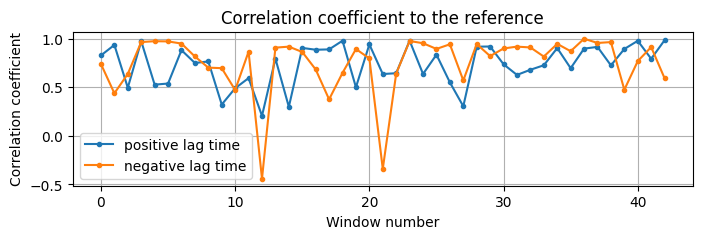

In [17]:
# Calculate the correlation coefficient between the coda and the reference coda
pcor_cc = np.zeros(shape=(nwin), dtype=np.float32)
ncor_cc = np.zeros(shape=(nwin), dtype=np.float32)
for i in range(nwin):
  pcor_cc[i] = np.corrcoef(tref[pwin_indx], tcur[i, pwin_indx])[0, 1]
  ncor_cc[i] = np.corrcoef(tref[nwin_indx], tcur[i, nwin_indx])[0, 1]

# Plot
plt.figure(figsize=(8,2));plt.grid(True)
plt.plot(pcor_cc, '.-', label='positive lag time')
plt.plot(ncor_cc, '.-', label='negative lag time')
plt.title('Correlation coefficient to the reference')
plt.ylabel('Correlation coefficient')
plt.xlabel('Window number')
plt.legend()

Next, measuring dv/v. 

In [18]:
# initializing arrays
dvv_stretch = np.zeros(shape=(nwin, 4), dtype=np.float32)

# define the parameters for stretching
para=dict()
para["freq"] = [freq1, freq2]
para["twin"] = [config_monito.coda_tbeg, config_monito.coda_tend]
para["dt"] = dt

Measuring dv/v on one component

Text(0, 0.5, '%')

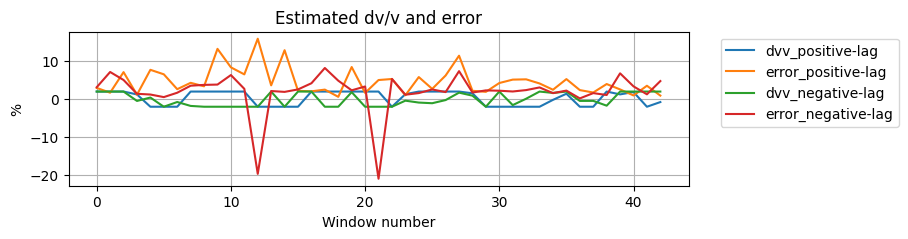

In [19]:

for ii in range(nwin):
    # casual and acasual lags for both ref and cur waveforms
    pcur = tcur[ii, pwin_indx]
    ncur = tcur[ii, nwin_indx]
    pref = tref[pwin_indx]
    nref = tref[nwin_indx]
    # functions working in time domain
    if config_monito.do_stretch:
        (
            dvv_stretch[ii, 0],
            dvv_stretch[ii, 1],
            cc,
            cdp,
        ) = stretching(pref, pcur, config_monito.epsilon, config_monito.nbtrial, para)
        (
            dvv_stretch[ii, 2],
            dvv_stretch[ii, 3],
            cc,
            cdp,
        ) = stretching(nref, ncur, config_monito.epsilon, config_monito.nbtrial, para)
plt.figure(figsize=(8,2))
plt.plot(dvv_stretch);plt.grid(True)
plt.legend(('dvv_positive-lag','error_positive-lag','dvv_negative-lag','error_negative-lag'),loc='upper right', bbox_to_anchor=(1.35,1))
plt.title('Estimated dv/v and error')
plt.xlabel('Window number')
plt.ylabel('%')

### Step 4: Measure dv/v on all cross-components

In [20]:
num_indx=86400//config.substack_len

# select the data from the three cross-component correlations
# that have sufficiently good windows
enz_system = [ "EN", "EZ", "NZ"]
comp = enz_system
indx0 = np.where( (cc_comp.lower() == comp[0].lower()) & cc_ngood==1)[0]
indx1 = np.where( (cc_comp.lower() == comp[1].lower()) & cc_ngood==1)[0]
indx2 = np.where( (cc_comp.lower() == comp[2].lower()) & cc_ngood==1)[0]
indx=np.intersect1d(np.intersect1d(indx0, indx1-(1*num_indx)),indx2-(3*num_indx))
nwin=len(indx)
print("Update the window number for the used components :", nwin)

# print(comp[0].lower(),indx0)
# print(comp[1].lower(),indx1)
# print(comp[2].lower(),indx2)
#print("Final common indx between multiple components: \n",indx)

indx_all=np.zeros(shape=(3,nwin),dtype=np.integer)
indx_all[0]=indx
indx_all[1]=indx+(1*num_indx)
indx_all[2]=indx+(3*num_indx)


Update the window number for the used components : 35


In [21]:
# initializing arrays again for multiple cross-component pairs
dvv_stretch = np.zeros(shape=(nwin, 4), dtype=np.float32)

In [22]:
print( src_sta, rec_sta, nwin)
nccomp=len(enz_system)

# initializing arrays
all_dvv= np.zeros(shape=(nccomp, nwin), dtype=np.float32)
all_err= np.zeros(shape=(nccomp, nwin), dtype=np.float32)
results_dvv= np.zeros(shape=(nwin), dtype=np.float32)
results_err= np.zeros(shape=(nwin), dtype=np.float32)
   
for icomp in range(0,nccomp):
    comp = enz_system[icomp]   

    indx=indx_all[icomp]

    # bandpass filter the data.
    tcur = np.zeros(shape=(len(indx),npts_one_segmt))
    for i in range(len(indx)):
      tcur[i,:]=bandpass(cc_array[indx[i]], freq1, freq2, int(1 / dt), corners=4, zerophase=True)
    
    # output stacked data
    (
        cc_final,
        ngood_final,
        stamps_final,
        tref,
        allstacks2,
        allstacks3,
        nstacks,
    ) = noise_module.stacking(tcur, cc_time[indx], cc_ngood[indx], config)
    
    for ii in range(nwin):
        # casual and acasual lags for both ref and cur waveforms
        pcur = tcur[ii, pwin_indx]
        ncur = tcur[ii, nwin_indx]
        pref = tref[pwin_indx]
        nref = tref[nwin_indx]
        # functions working in time domain
        if config_monito.do_stretch:
            (
                dvv_stretch[ii, 0],
                dvv_stretch[ii, 1],
                cc,
                cdp,
            ) = stretching(pref, pcur, config_monito.epsilon, config_monito.nbtrial, para)
            (
                dvv_stretch[ii, 2],
                dvv_stretch[ii, 3],
                cc,
                cdp,
            ) = stretching(nref, ncur, config_monito.epsilon, config_monito.nbtrial, para)
    all_dvv[icomp]=(dvv_stretch[:, 0]+dvv_stretch[:, 2])/2.0
    all_err[icomp]=np.sqrt(dvv_stretch[:, 1]**2+dvv_stretch[:, 3]**2)
    print('component: ',comp,' completed. ')
    results_dvv+=all_dvv[icomp]
    results_err+=all_err[icomp]**2
results_dvv=results_dvv/nccomp
results_err=np.sqrt(results_err)
print(all_dvv.shape, results_dvv.shape, )
nwin=len(results_dvv)
            

CI.LJR CI.LJR 35
component:  EN  completed. 
component:  EZ  completed. 
component:  NZ  completed. 
(3, 35) (35,)


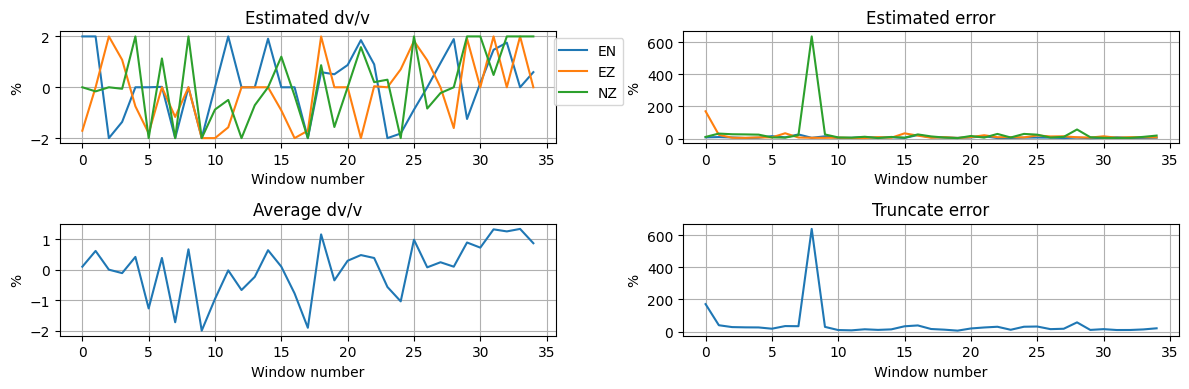

In [23]:
fig,ax=plt.subplots(2,2,figsize=(12,4))
ax[0,0].plot(all_dvv.T)
ax[0,0].legend(enz_system, loc='upper right', bbox_to_anchor=(1.15,1))
ax[0,0].grid(True)
ax[0,0].set_title('Estimated dv/v')
ax[0,0].set_xlabel('Window number')
ax[0,0].set_ylabel('%')

ax[0,1].plot(all_err.T);ax[0,1].grid(True);#ax[0,1].set_ylim(0,100)
ax[0,1].set_title('Estimated error')
ax[0,1].set_xlabel('Window number')
ax[0,1].set_ylabel('%')

ax[1,0].plot(results_dvv.T);ax[1,0].grid(True)
ax[1,0].set_title('Average dv/v')
ax[1,0].set_xlabel('Window number')
ax[1,0].set_ylabel('%')

ax[1,1].plot(results_err.T);ax[1,1].grid(True)
ax[1,1].set_title('Truncate error')
ax[1,1].set_xlabel('Window number')
ax[1,1].set_ylabel('%')

plt.tight_layout()

### Step 5: Measure attenuation parameter -- intrinsic absorption parameter b
Preparing mean-squared values in time seires for measuring intrinsic parameter. We follow these steps:
* Prepare smoothed mean-squared data (msv) in a given frequency band,
* Get the average msv (msv_mean) from all components, and also the symmetric msv (fmsv_mean)
* Measure intrinsic absorption parameter b (results_intb) and transfer it to intrinsic Q (Qi)

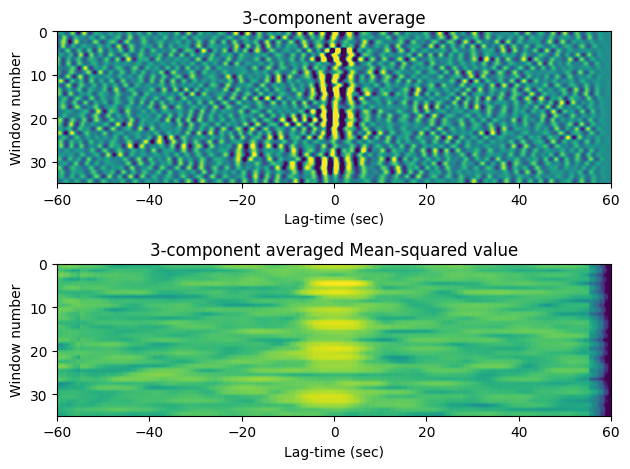

In [24]:
from matplotlib.colors import LogNorm
#enz_system = ["EN", "EZ", "NZ"]
nccomp=len(enz_system)
winlen=config_monito.smooth_winlen

# Restore calendar time from cc_time array 
win_time=[]

# initializing arrays 
tcur_temp1 = np.zeros(shape=(num_chunk*num_segmts, npts_one_segmt))
msv=np.zeros((nccomp, num_chunk*num_segmts, npts_one_segmt))
msv_temp=np.zeros((num_chunk*num_segmts, npts_one_segmt))

# get all components average
for icomp in range(0,nccomp):
    comp = enz_system[icomp]
    
    # bandpass filter the data.
    tcur_temp2 = np.zeros(shape=(len(indx),npts_one_segmt))
    for i in range(len(indx)):
        tcur_temp2[i,:]=bandpass(cc_array[indx[i]], freq1, freq2, int(1 / dt), corners=4, zerophase=True)
        win_time.append(datetime.utcfromtimestamp(int(cc_time[indx[i]])).strftime("%Y-%m-%dT%H:%M"))
        #print(icomp, i , cc_time[indx[i]],datetime.utcfromtimestamp(int(cc_time[indx[i]])).strftime("%Y-%m-%dT%H:%M"))
        
        para = { 'winlen':winlen, 'dt':dt , 'npts': len(tcur_temp2[i])}
        msv[icomp,i]=get_smooth(tcur_temp2[i], para)
        #print(tcur_temp.shape,msv[icomp].shape)

    tcur_temp1[0:len(indx)]=tcur_temp1[0:len(indx)]+tcur_temp2
    msv_temp=msv_temp+msv[icomp]

tcur_avef = np.zeros(shape=(nwin, npts_one_segmt))
msv_mean = np.zeros(shape=(nwin, npts_one_segmt))
#print(nwin, tcur_avef.shape, msv.shape, msv_mean.shape)

tcur_avef = tcur_temp1[:nwin,:]/nccomp
msv_mean = msv_temp[:nwin,:]/nccomp
msv_mean = msv_mean/np.max(msv_mean)
del  tcur_temp1, tcur_temp2, msv_temp 

fig,ax=plt.subplots(2,1)
ax[0].imshow(tcur_avef, extent=[-config.maxlag,config.maxlag,nwin,0],aspect='auto',vmin=-0.001,vmax=0.001)
ax[0].set_title(str(nccomp)+"-component average")
ax[0].set_ylabel('Window number')
ax[0].set_xlabel('Lag-time (sec)')
ax[1].imshow(msv_mean, extent=[-config.maxlag,config.maxlag,nwin,0],aspect='auto', norm=LogNorm(vmin=0.00001, vmax=1))
ax[1].set_title(str(nccomp)+'-component averaged Mean-squared value')
ax[1].set_xlabel('Lag-time (sec)')
ax[1].set_ylabel('Window number')
plt.tight_layout()

    

In [25]:
half_npts=(npts_one_segmt-1)//2
fmsv_mean=np.zeros((nwin,2,half_npts+1))

for ntw in range(nwin):
    sym=get_symmetric(msv_mean[ntw],half_npts)
    fmsv_mean[ntw][0]=np.arange(0,config.maxlag+dt,dt)
    fmsv_mean[ntw][1]=sym


Parameters for getting the sum of squared residuals (SSR) between observed energy densities (Eobs) and synthesized energy densities (Esyn)

In [26]:
twinbe=np.ndarray((1,1,2))
twinbe[0,0,0]=config_monito.atten_tbeg
twinbe[0,0,1]=config_monito.atten_tend

cvel=config_monito.cvel # Rayleigh wave velocities over the freqency bands
vdist=np.zeros((1))     # station distance
mfpx=np.zeros(1)        # mean_free_path search array
intby=np.zeros(80)      # intrinsic_b search array
config_monito.intb_interval_base=0.01 # interval base for a grid-searching process

In [27]:
# getting the sum of squared residuals (SSR) between Eobs and Esyn  
SSR_final=np.zeros((len(mfpx),len(intby)))
SSR=np.zeros((nwin,1,len(mfpx),len(intby)))

for ntw in range(nwin):
    data=np.zeros(shape=(1,2,half_npts+1))
    data[0,:,:]=fmsv_mean[ntw]
    #print(data.shape,fmsv_mean[ntw].shape)
    # parameters for getting the sum of squared residuals (SSR) between Eobs and Esyn 
    para={ 'fb':0 , 'vdist':vdist, 'npts':npts_one_segmt, 'dt':dt, 'cvel':cvel, \
        'mfp':mfpx, 'intb':intby,'twin':twinbe, 'fmsv':data }
    # call function get_SSR
    SSR_final, mfpx, intby = get_SSR(1, para )

    SSR[ntw][0]=SSR_final
print(SSR.shape)

(35, 1, 1, 80)


In [28]:
def plot_fitting_result(mean_free,intrinsic_b,tt,Eobs,Esyn,fname,dist,twind,fmin,fmax,win_num):
    plt.figure(figsize=(6,2))
    plt.yscale('log', base=10)

    pymax=np.max(Eobs[:-2]*5)
    pymin=10**(-3)
    print( pymin , pymax )
    plt.ylim( pymin , pymax )
    plt.plot( tt, Eobs, "k-", linewidth=1)
    plt.plot( tt, Esyn, "b--", linewidth=1)
    plt.plot([twind[0],twind[0],twind[-1],twind[-1],twind[0]],[pymin, pymax,pymax,pymin,pymin],"r", linewidth=2)

    plt.title("%s @%4.2f-%4.2f Hz, intrinsic b: %.2f, Window no. %d" \
            % ( fname,fmin,fmax,intrinsic_b, win_num))
    plt.xlabel("Lag time (sec)")
    plt.ylabel("Energy density Amp")
    plt.tight_layout()   
    plt.show()
                    

Getting optimal fit in grid-searching

2024-04-26 16:34:02,803 140422299808768 INFO attenuation_utils.get_optimal_Esyn():  Station Pair: (CI.LJR, CI.LJR), frequency band 0.25-0.5Hz, intrinsic_b [0.06], mean_free: [0.2]
2024-04-26 16:34:02,807 140422299808768 INFO attenuation_utils.get_optimal_Esyn():  Station Pair: (CI.LJR, CI.LJR), frequency band 0.25-0.5Hz, intrinsic_b [0.01], mean_free: [0.2]
2024-04-26 16:34:02,810 140422299808768 INFO attenuation_utils.get_optimal_Esyn():  Station Pair: (CI.LJR, CI.LJR), frequency band 0.25-0.5Hz, intrinsic_b [0.01], mean_free: [0.2]
2024-04-26 16:34:02,813 140422299808768 INFO attenuation_utils.get_optimal_Esyn():  Station Pair: (CI.LJR, CI.LJR), frequency band 0.25-0.5Hz, intrinsic_b [0.01], mean_free: [0.2]
2024-04-26 16:34:02,816 140422299808768 INFO attenuation_utils.get_optimal_Esyn():  Station Pair: (CI.LJR, CI.LJR), frequency band 0.25-0.5Hz, intrinsic_b [0.34], mean_free: [0.2]
2024-04-26 16:34:02,819 140422299808768 INFO attenuation_utils.get_optimal_Esyn():  Station Pair: (C

0.001 0.9712036004066429


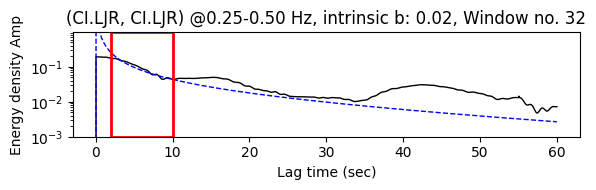

2024-04-26 16:34:03,323 140422299808768 INFO attenuation_utils.get_optimal_Esyn():  Station Pair: (CI.LJR, CI.LJR), frequency band 0.25-0.5Hz, intrinsic_b [0.01], mean_free: [0.2]
2024-04-26 16:34:03,327 140422299808768 INFO attenuation_utils.get_optimal_Esyn():  Station Pair: (CI.LJR, CI.LJR), frequency band 0.25-0.5Hz, intrinsic_b [0.01], mean_free: [0.2]


In [29]:
# getting the optimal value from the SSR
result_intb=np.zeros((nwin,1))
result_mfp=np.zeros((nwin, 1))

Eobs=np.ndarray((1,half_npts))
Esyn=np.ndarray((1,half_npts))
aa=0
r=np.take(vdist[aa],0) 

fmin=freq1
fmax=freq2
wfcen=2.0*np.pi*((freq1+freq2)/2.0)

for ntw in range(nwin):

    data=np.zeros(shape=(1,2,half_npts+1))
    data[0,:,:]=fmsv_mean[ntw]
    # parameters for getting optimal value from the sum of squared residuals (SSR) between Eobs and Esyn 
    para={ 'fb':0, 'fmin':fmin, 'fmax':fmax, 'vdist':vdist, 'npts':npts_one_segmt, 'dt':dt, 'cvel':cvel, 'filenum':aa, \
        'mfp':mfpx, 'intb':intby, 'twin':twinbe, 'fmsv':data, 'SSR':SSR[ntw] , 'sta':sta_pair}
    # call function get_optimal
    result_intb[ntw], result_mfp[ntw], Eobs, Esyn = get_optimal_Esyn(1,para)
    # plotting fitting results
    if ntw == 32:
        plot_fitting_result(result_mfp,result_intb[ntw],data[0,0,:], 
                    Eobs,Esyn,sta_pair,vdist[0],twinbe[0][0],fmin,fmax,ntw)
    
intQ=np.zeros((nwin,1)) 
intQ=wfcen/result_intb


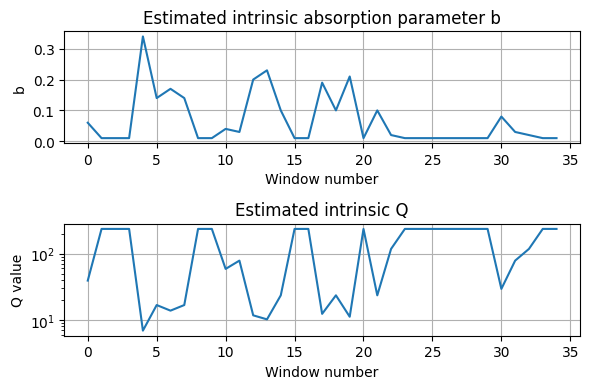

In [30]:
fig,ax=plt.subplots(2,1,figsize=(6,4))
ax[0].plot(result_intb, label='intrinsic b')
ax[0].grid(True)
ax[0].set_title('Estimated intrinsic absorption parameter b')
ax[0].set_xlabel('Window number')
ax[0].set_ylabel('b')

ax[1].plot(intQ, label='Q')
ax[1].set_yscale("log")
ax[1].grid(True)
ax[1].set_title('Estimated intrinsic Q')
ax[1].set_xlabel('Window number')
ax[1].set_ylabel('Q value')
plt.tight_layout()

In [31]:
# Save config parameters
monito_config_fn='monito_config.yml'
config_monito.save_yaml(monito_config_fn)

### Step 6: Output results as a csv file

In [32]:
# Restore calendar time from cc_time array 
#cal_time=win_time[:nwin]
cal_time=win_time[:len(win_time)//3]
print(len(cal_time),results_dvv.shape,result_intb[:,0].shape, intQ.shape )


35 (35,) (35,) (35, 1)


In [33]:
import pandas as pd

fieldnames = ['time', 'dvv','err','int_b','wfcen', 'Q']
fcsv="Monitoring_output.csv"
data={
'time': cal_time,
'dvv':  results_dvv,
'err':  results_err,
'int_b': result_intb[:,0],
'wfcen': np.full((nwin),wfcen),
'Q': intQ[:,0],
}

df=pd.DataFrame(data)
df.to_csv(fcsv,columns=fieldnames,sep=',',index = None, header=True, float_format="%.4f" )

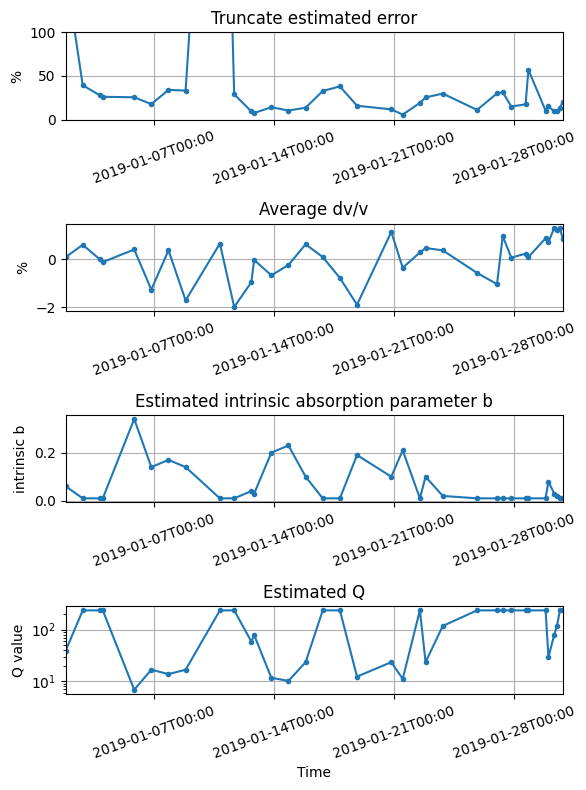

In [34]:
import matplotlib.dates as mdates

fig,ax=plt.subplots(4,1,figsize=(6,8))

t=[datetime.strptime(d,'%Y-%m-%dT%H:%M').strftime('%Y-%m-%dT%H:%M') for d in cal_time]
t=pd.to_datetime(t)

ax[0].set_ylim(0,100)
ax[0].plot_date(t, results_err, '.-', label='error of dv/v (%)')
ax[0].set_title('Truncate estimated error')
ax[0].set_ylabel('%')

ax[1].plot_date(t, results_dvv, '.-', label='dv/v (%)')
ax[1].set_title('Average dv/v')
ax[1].set_ylabel('%')

ax[2].plot_date(t, result_intb[:,0], '.-', label='intrinsic b')
ax[2].set_title('Estimated intrinsic absorption parameter b')
ax[2].set_ylabel('intrinsic b')

ax[3].plot_date(t,intQ[:,0],'.-',  label='Q')
ax[3].set_title('Estimated Q')
ax[3].set_ylabel('Q value')
ax[3].set_xlabel('Time')
ax[3].set_yscale('log')
for k in range(4):
    ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%dT%H:%M'))
    ax[k].set_xlim(np.datetime64(t[0]), np.datetime64(t[-1]))
    ax[k].xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax[k].tick_params('x',labelrotation=20)
    ax[k].grid(True)

plt.tight_layout()

Save the output csv file on S3-bucket

In [35]:
my_s3bucket="s3://YOUR_S3-bucket/"

command="aws s3 cp "+fcsv+" "+my_s3bucket
print(command)
#os.system(command)

command="aws s3 cp "+xcorr_config_fn+" "+my_s3bucket
print(command)
#os.system(command) 

command="aws s3 cp "+monito_config_fn+" "+my_s3bucket
print(command)
#os.system(command) 


aws s3 cp Monitoring_output.csv s3://YOUR_S3-bucket/
aws s3 cp xcorr_config.yml s3://YOUR_S3-bucket/
aws s3 cp monito_config.yml s3://YOUR_S3-bucket/
